<table style="border: none;">
<tr>
<td style="border: none;"><img src="./figures/nova_logo.png" alt="Drawing" style="width: 150px;height: 200px"/></td>
<td style="border: none;">
    <h1><strong>Machine Learning Project : To Grant Or Not To Grant</strong></h1>
    <h2><strong>Part 2/2 : Model Development</strong></h2>
    <p>Group 48 -   
    Afonso Lopes - 202111540  &bull; 
     Ana Duarte - 20240545  &bull; 
     Diogo Fernandes - 20220507  &bull; 
     Pedro Campino - 20240537</p>
    <p>23/04/2024</p>
</td>
</tr>
</table>


**Table of contents**<a id='toc0_'></a>    
- 1. [Pipeline](#toc1_)    
  - 1.1. [Custom Classes](#toc1_1_)    
  - 1.2. [Preprocessing](#toc1_2_)    
  - 1.3. [Feature Selection](#toc1_3_)    
  - 1.4. [Model Development](#toc1_4_)    
    - 1.4.1. [Base Models](#toc1_4_1_)    
    - 1.4.2. [Ensemble Models](#toc1_4_2_)    
    - 1.4.3. [Optimizing MLP hyperparameters](#toc1_4_3_)    
    - 1.4.4. [Bagging with MLP optimized & GBoost optimization](#toc1_4_4_)    
    - 1.4.5. [Stacking](#toc1_4_5_)    
    - 1.4.6. [Preprocessing Optimization](#toc1_4_6_)    
- 2. [Open Ended Section - Oversampling & OVA](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

To run the notebook please download and unzip the folder from the link and put it inside the repository root folder

`https://drive.google.com/file/d/1ofrK56VcwspmwElFun3koLs93eOeP5G7/view?usp=sharing`

In [43]:
### Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

### Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline

### Preprocessing and Feature Selection
from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from category_encoders import CountEncoder
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

### Models
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.ensemble import StackingClassifier
from sklearn.multiclass import OneVsRestClassifier


### Model Analysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import label_binarize

### Misc
import pandas as pd
import numpy as np
import os
import requests
import time
import warnings
from joblib import dump, load
from scipy import stats
from IPython.display import display
import re

In [45]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
warnings.filterwarnings("ignore")

In [175]:
telegram_api_token = os.getenv("telegram_api_token")
telegram_chat_id = os.getenv("telegram_chat_id")


def notify(text="Execution completed."):
    """
    Sends a notification through the telegram api.
    """
    if telegram_api_token and telegram_chat_id:
        requests.post(
            "https://api.telegram.org/"
            + "bot{}/sendMessage".format(telegram_api_token),
            params=dict(chat_id=telegram_chat_id, text=text),
        )
    else:
        pass


def compare_models_df(gs, features_of_interest=None, round=2):
    """
    Receives a gridsearch object, extracts train and validation scores and creates a dataframe.
    """
    results = {
        key: gs.cv_results_[key]
        for key in [
            "mean_train_score",
            "std_train_score",
            "mean_test_score",
            "std_test_score",
            "params",
        ]
    }
    results_df = pd.DataFrame(
        {
            "model": [type(params["model"]).__name__ for params in results["params"]],
            "model_parameters": [
                {
                    key: value
                    for key, value in params.items()
                    if key == "model" or key.startswith("model__")
                }
                for params in results["params"]
            ],
            "preprocessing": [
                getattr(params.get("preprocessing", None), "name", "None")
                for params in results["params"]
            ],
            **results,
        }
    )

    results_df["F1 Train Score"] = (
        results_df["mean_train_score"].round(round).astype(str)
        + " ± "
        + results_df["std_train_score"].round(round).astype(str)
    )
    results_df["F1 Validation Score"] = (
        results_df["mean_test_score"].round(round).astype(str)
        + " ± "
        + results_df["std_test_score"].round(round).astype(str)
    )

    numerical_cols = results_df.select_dtypes(include="number").columns
    results_df[numerical_cols] = results_df[numerical_cols].round(round)

    if features_of_interest:
        for key, col_name in features_of_interest.items():
            results_df[col_name] = results_df["params"].apply(lambda x: x.get(key))

    desired_last_columns = ["F1 Train Score", "F1 Validation Score"]
    other_columns = [
        col for col in results_df.columns if col not in desired_last_columns
    ]
    results_df = results_df[other_columns + desired_last_columns]
    return results_df.drop(
        [
            "params",
            "mean_train_score",
            "std_train_score",
            "mean_test_score",
            "std_test_score",
        ],
        axis=1,
    )


def compare_models_boxplots(gs, figsize=(12, 5)):
    results = gs.cv_results_
    results_no_folder = compare_models_df(gs)
    validation_scores_folds = np.array(
        [results[f"split{fold}_test_score"] for fold in range(3)]
    ).T

    validation_scores_folds = pd.DataFrame(
        validation_scores_folds,
        columns=[f"Validation F1_Fold_{fold}" for fold in range(3)],
        index=results_no_folder.index,
    )

    df_folds = pd.concat(
        (
            results_no_folder["model"],
            validation_scores_folds,
        ),
        axis=1,
    )

    df_folds = df_folds.groupby("model").mean().T
    means = df_folds.mean(axis=0)

    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(data=df_folds, color="grey", ax=ax)
    x_positions = range(len(means))
    ax.scatter(
        x_positions, means, color="black", zorder=2, marker="^", s=20, label="mean"
    )
    ax.legend(loc="lower right", fontsize=12)
    ax.set_xlabel("")
    ax.set_xticks(range(len(df_folds.columns)))
    ax.set_xticklabels(df_folds.columns, fontsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.set_ylabel("F1 Score", fontsize=14)

    return fig


def transform_zip(zip_code):
    """
    Preprocessing helper function to label zip codes.
    """
    zip_code_str = str(zip_code)
    if (
        len(zip_code_str) < 5
        or zip_code_str.startswith("1")
        or zip_code_str.startswith("2")
        or zip_code_str.startswith("3")
        or zip_code_str.startswith("4")
    ):
        return "Eastern"
    elif (
        (zip_code_str.startswith("5"))
        | (zip_code_str.startswith("6"))
        | (zip_code_str.startswith("7"))
        | (zip_code_str.startswith("8"))
    ):
        return "Central"
    elif zip_code_str.startswith("9"):
        return "Western"


def custom_mutual_info_classif(X, y):
    """
    Enables n_neighbors declaration within the pipeline.
    """
    return mutual_info_classif(X, y, n_neighbors=35)


def analyse_best_model(gs):
    """
    Receives a gridsearch object and, for the best estimator, outputs the classification report in a dataframe, confusion matrix and ROC and PR curves plots.
    """
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X)

    # Classification Report
    report_dict = classification_report(y, y_pred, zero_division=1, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose().round(2)
    display(report_df)

    cm = confusion_matrix(y, y_pred, normalize="true") * 100
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=gs.best_estimator_.classes_
    )
    fig, ax = plt.subplots()
    disp = disp.plot(cmap="Greys", ax=ax, values_format=".0f")
    disp.im_.set_clim(0, 100)

    plt.title("Confusion Matrix\n (row-wise percentages)")
    plt.xticks(rotation=90)
    plt.show()

    # Curves
    classes = list(set(y))
    y_test_binarized = label_binarize(y, classes=classes)

    # Predict probabilities for each class
    y_pred_proba = best_model.predict_proba(X)

    curves, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curve
    ax = axes[0]
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Multiclass ROC Curve")
    ax.legend(loc="lower left", bbox_to_anchor=(1.1, 0.0))

    # Precision-Recall Curve
    ax = axes[1]
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(
            y_test_binarized[:, i], y_pred_proba[:, i]
        )
        avg_precision = average_precision_score(
            y_test_binarized[:, i], y_pred_proba[:, i]
        )
        ax.plot(
            recall, precision, label=f"Class {class_label} (AP = {avg_precision:.2f})"
        )

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Multiclass Precision-Recall Curve")
    ax.legend(loc="lower left", bbox_to_anchor=(1.1, 0.0))

    plt.tight_layout()
    plt.show()

    return report_df, fig, curves


def get_predictions_csv(gs):
    """
    Recives a gridsearch object and outputs a csv file with the test predictions ready to submit on Kaggle.
    """
    y_test = gs.best_estimator_.predict(test)
    predictions = pd.DataFrame(
        y_test, columns=["Claim Injury Type"], index=test.index
    ).reset_index()
    predictions.to_csv("predictions.csv", index=False)

In [47]:
train = pd.read_csv("./runs/train_data.csv", low_memory=False)
test = pd.read_csv("./runs/test_data.csv")
us_zips = pd.read_csv("./runs/zip_code_database.csv")

In [48]:
# Drop duplicates
train = train.drop_duplicates()

# Define Claim Identifier as the index
train.set_index("Claim Identifier", inplace=True)
test.set_index("Claim Identifier", inplace=True)

# Drop rows that have missing values in the target
train = train.dropna(subset=["Claim Injury Type"])

# Drop cols that are not on test dataset
train = train.drop(columns=["Agreement Reached", "WCB Decision"])

In [49]:
cause_injury = {
    "I. Burn or Scald - Heat or Cold Exposures - Contact With": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "11",
        "14",
        "84",
    ],
    "II. Caught In, Under or Between": ["10", "12", "13", "20"],
    "III. Cut, Puncture, Scrape Injured By": ["15", "16", "17", "18", "19"],
    "IV. Fall, Slip or Trip Injury": [
        "25",
        "26",
        "27",
        "28",
        "29",
        "30",
        "31",
        "32",
        "33",
    ],
    "V. Motor Vehicle": ["40", "41", "45", "46", "47", "48", "50"],
    "VI. Strain or Injury By": [
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "58",
        "59",
        "60",
        "61",
        "97",
    ],
    "VII. Striking Against or Stepping On": [
        "65",
        "66",
        "67",
        "68",
        "69",
        "70",
    ],
    "VIII. Struck or Injured By": [
        "74",
        "75",
        "76",
        "77",
        "78",
        "79",
        "80",
        "81",
        "85",
        "86",
    ],
    "IX. Rubbed or Abraded By": ["94", "95"],
    "X. Miscellaneous Causes": [
        "82",
        "83",
        "87",
        "88",
        "89",
        "90",
        "91",
        "93",
        "96",
        "98",
        "99",
    ],
}


nature_injury = {
    "specific_injury": [
        "1",
        "2",
        "3",
        "4",
        "7",
        "10",
        "13",
        "16",
        "19",
        "22",
        "25",
        "28",
        "30",
        "31",
        "32",
        "34",
        "36",
        "37",
        "38",
        "40",
        "41",
        "42",
        "43",
        "46",
        "47",
        "49",
        "52",
        "53",
        "54",
        "55",
        "58",
        "59",
    ],
    "occupational_disease": [
        "60",
        "61",
        "62",
        "63",
        "64",
        "65",
        "66",
        "67",
        "68",
        "69",
        "70",
        "71",
        "72",
        "73",
        "74",
        "75",
        "76",
        "77",
        "78",
        "79",
        "80",
        "83",
    ],
    "multiple_injuries": ["90", "91"],
}


body_part = {
    "head": [
        "10",
        "11",
        "12",
        "13",
        "13A",
        "13B",
        "13C",
        "14",
        "14A",
        "14B",
        "14C",
        "15",
        "16",
        "17",
        "18",
        "19",
    ],
    "neck": ["20", "21", "22", "23", "24", "25", "26"],
    "upper_extremities": [
        "30",
        "31",
        "32",
        "33",
        "34",
        "35",
        "36",
        "36A",
        "36B",
        "36C",
        "36D",
        "36E",
        "36F",
        "36G",
        "36H",
        "36I",
        "36J",
        "36K",
        "36L",
        "36M",
        "36N",
        "36O",
        "36P",
        "37",
        "37A",
        "37B",
        "37C",
        "38",
        "39",
    ],
    "trunk": [
        "40",
        "41",
        "42",
        "43",
        "44",
        "45",
        "46",
        "47",
        "48",
        "49",
        "60",
        "61",
        "62",
        "63",
    ],
    "lower_extremities": [
        "50",
        "51",
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "57A",
        "57B",
        "57C",
        "57D",
        "57E",
        "57F",
        "57G",
        "58",
        "58A",
        "58B",
        "58C",
    ],
    "multiple_body_parts": ["64", "65", "66", "90", "91", "99"],
}

In [50]:
X = train.drop(["Claim Injury Type"], axis=1)

y = train[["Claim Injury Type"]]
y = y.to_numpy().ravel()

In [51]:
# Numeric columns
num_cols = [
    "Age at Injury",
    "Average Weekly Wage",
    "Birth Year",
    "IME-4 Count",
    "Accident Date",
    "Assembly Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
]

# Categorical columns
cat_cols = [
    "Carrier Name",
    "County of Injury",
    "Medical Fee Region",
    "Industry Code",
    "Industry Code Description",
    "District Name",
    "WCIO Cause of Injury Code",
    "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Code",
    "WCIO Nature of Injury Description",
    "WCIO Part Of Body Code",
    "WCIO Part Of Body Description",
    "Zip Code",
    "OIICS Nature of Injury Description",
    "Accident Date",
]

# Binary columns
bin_cols = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "COVID-19 Indicator",
    "Gender",
    "Accident Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
    "Assembly Date",
    "Age at Injury",
]

# 1. <a id='toc1_'></a>[Pipeline](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Custom Classes](#toc0_)

In [52]:
# _______________________NUM PIPELINE_______________________
class MissingValueImputer_Numeric(BaseEstimator, TransformerMixin):
    """
    Filling Missing values in numeric and date-related columns.

    - Imputes missing values for "Birth Year" and "Age at Injury" based on their relationship with "Accident Date".
    - Fills missing values in "IME-4 Count" with 0, assuming NAs represent zeros.
    - Assigns a placeholder future date for missing values in date columns "First Hearing Date" and "C-2 Date".

    Returns:
    ----------
    - DataFrame: The transformed DataFrame with missing values handled appropriately.
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Filling Missing values.
        """
        X = X.copy()

        # Birth Year or Age at Injury are NA
        # Ensure 'Accident Date' is in datetime format
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")
        # Extract the year from 'Accident Date' for later computations
        X["Accident Year"] = X["Accident Date"].dt.year
        # Imputing calculated Birth Year / Age at Injury
        X.loc[(X["Birth Year"].isna()) & (X["Age at Injury"].notna()), "Birth Year"] = (
            X["Accident Year"] - X["Age at Injury"]
        )
        X.loc[
            (X["Age at Injury"].isna()) & (X["Birth Year"].notna()), "Age at Injury"
        ] = (X["Accident Year"] - X["Birth Year"])
        # Drop the 'Accident Year' column after computation
        X.drop(columns=["Accident Year"], inplace=True)

        # After verifying that there where no zeros in IME-4 Count, it was concluded that NAs most likely represented zeros
        X["IME-4 Count"] = X["IME-4 Count"].fillna(0)

        # Most missing values in dates seem to be meaningful, as they likely mean the event never occured. In order to preserve their meaning, we will fill them with a clearly invalid future placeholder.
        X["First Hearing Date"] = X["First Hearing Date"].fillna(
            pd.Timestamp("2100-01-01")
        )
        X["C-2 Date"] = X["C-2 Date"].fillna(pd.Timestamp("2100-01-01"))

        return X


class AnomalyFixer_Numeric(BaseEstimator, TransformerMixin):
    """
    Transformer to handle anomalies such as zero or invalid values in columns like 'Age at Injury' and 'Birth Year'.
    """

    def __init__(self):
        self.medians = {}

    def fit(self, X, y=None):
        """
        Fit the transformer by computing median values for anomaly correction.
        """
        X = X.copy()

        # Ensure 'Accident Date' is in datetime format
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")

        # Calculate medians for date correction
        for col in ["C-2 Date", "C-3 Date", "Assembly Date", "First Hearing Date"]:
            X[col] = pd.to_datetime(X[col], errors="coerce")
            self.medians[col] = X[col].median()

        return self

    def transform(self, X):
        """
        Transform the data by fixing anomalies such as zeros in 'Age at Injury' and 'Birth Year'.
        """
        X = X.copy()

        # Birth Year or Age at Injury are equal to zero
        # Ensure 'Accident Date' is in datetime format
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")
        # Extract the year from 'Accident Date' for later computations
        X["Accident Year"] = X["Accident Date"].dt.year
        # Imputing calculated Birth Year / Age at Injury
        X.loc[(X["Birth Year"] == 0) & (X["Age at Injury"] != 0), "Birth Year"] = (
            X["Accident Year"] - X["Age at Injury"]
        )
        X.loc[(X["Age at Injury"] == 0) & (X["Birth Year"] != 0), "Age at Injury"] = (
            X["Accident Year"] - X["Birth Year"]
        )
        # Drop the 'Accident Year' column after computation
        X.drop(columns=["Accident Year"], inplace=True)

        # Fixing cases where Accident Date happens after other dates
        for col in ["C-2 Date", "C-3 Date", "Assembly Date", "First Hearing Date"]:
            X[col] = pd.to_datetime(X[col], errors="coerce")
            condition = (X[col] - X["Accident Date"]).dt.days < 0
            X.loc[condition, col] = self.medians[col]

        return X


class Num_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        date_columns=[
            "Accident Date",
            "Assembly Date",
            "C-2 Date",
            "C-3 Date",
            "First Hearing Date",
        ],
        birth_column="Birth Year",
        weekly_wage_column="Average Weekly Wage",
    ):
        """
        Transformer to process both date columns and numeric features.

        This class combines date processing (calculating date-based features) and numeric feature engineering
        (calculating features like age, age interactions, etc.) into one step.

        Parameters:
        ----------
        - date_columns: list of str
            List of columns containing date data to be processed.
        - birth_column: str, default="Birth Year"
            The column name containing the birth year of individuals.
        - weekly_wage_column: str, default="Average Weekly Wage"
            The column name for average weekly wage to be used in feature interactions.
        """
        self.date_columns = date_columns
        self.birth_column = birth_column
        self.weekly_wage_column = weekly_wage_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Step 1: Convert date columns to datetime and calculate date-based features
        for col in self.date_columns:
            X[col] = pd.to_datetime(X[col])

        X["Accident to Assembly Days"] = (
            X["Assembly Date"] - X["Accident Date"]
        ).dt.days
        X["Accident to First Hearing Days"] = (
            X["First Hearing Date"] - X["Accident Date"]
        ).dt.days
        X["Accident to C-2 Days"] = (X["C-2 Date"] - X["Accident Date"]).dt.days
        X["Accident to C-3 Days"] = (X["C-3 Date"] - X["Accident Date"]).dt.days

        # Step 2: Generate additional numeric features based on birth year and other columns
        current_year = pd.Timestamp.now().year
        X["Age"] = current_year - X[self.birth_column]

        # Create year, month, and quarter features from 'Accident Date'
        X["Accident Year"] = X["Accident Date"].dt.year
        X["Accident Month"] = X["Accident Date"].dt.month
        X["Accident Quarter"] = X["Accident Date"].dt.quarter

        # Additional transformations using Age
        X["Relative Age at Injury"] = X["Age"] - X["Age at Injury"]
        X["Age Squared"] = X["Age"] ** 2
        X["Age x Weekly Wage"] = X["Age"] * X[self.weekly_wage_column]

        # Drop the original date columns after transformation
        X = X.drop(self.date_columns, axis=1)

        return X


class OutlierCapper(BaseEstimator, TransformerMixin):
    """
    Transformer to cap outliers in a DataFrame.
    Can use IQR or percentile method.

    Parameters:
    ----------
    method : str, optional (default="iqr")
        The method to use for outlier capping. Options are:
        - "iqr": Use the Interquartile Range (IQR) to define caps.
        - "percentile": Use lower and upper percentiles to define caps.

    lower_quantile : float, optional (default=0.01)
        The lower quantile for capping when using the "percentile" method.
    upper_quantile : float, optional (default=0.99)
        The upper quantile for capping when using the "percentile" method.
    iqr_multiplier : float, optional (default=1.5)
        The multiplier for the IQR to define caps when using the "iqr" method.

    Returns:
    ----------
    - DataFrame : The transformed DataFrame with the values capped.
    """

    def __init__(
        self, method="iqr", lower_quantile=0.01, upper_quantile=0.99, iqr_multiplier=1.5
    ):

        self.method = method
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.iqr_multiplier = iqr_multiplier

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        self.caps_ = {}

        for col in X.columns:
            if self.method == "iqr":
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_cap = Q1 - self.iqr_multiplier * IQR
                upper_cap = Q3 + self.iqr_multiplier * IQR

            elif self.method == "percentile":
                lower_cap = X[col].quantile(self.lower_quantile)
                upper_cap = X[col].quantile(self.upper_quantile)

            self.caps_[col] = (lower_cap, upper_cap)
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        for col in X.columns:
            lower_cap, upper_cap = self.caps_[col]
            X[col] = X[col].clip(lower=lower_cap, upper=upper_cap)
        return X


# _______________________CATEGORICAL PIPELINE_______________________


class Categorical_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        columns_to_modify=[
            "WCIO Cause of Injury Code",
            "WCIO Nature of Injury Code",
            "WCIO Part Of Body Code",
            "Zip Code",
            "Accident Date",
        ],
        dict_mappings=[cause_injury, nature_injury, body_part],
    ):
        """
        Transformer to group code features into supra codes, process zip codes, and determine accident seasons.
        Drops the original code columns.

        Parameters:
        ----------
        - columns_to_modify: lst of str, optional(default=["WCIO Cause of Injury Code", "WCIO Nature of Injury Code","WCIO Part Of Body Code", "Zip Code", "Accident Date"])
        List of columns to be processed or grouped.
        - dict_mappings: lst of dict, optional(default=[cause_injury, nature_injury, body_part])
        List of dictionaries mapping codes to supra codes.

        Returns:
        ----------
        - DataFrame : The transformed DataFrame with the new features, such as supra codes, processed zip codes with regions, accident seasons, and without the original columns.
        """

        self.columns_to_modify = columns_to_modify
        self.dict_mappings = dict_mappings

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X = X.copy()
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # CAUSE OF INJURY
        code_to_category = {
            code: category for category, codes in cause_injury.items() for code in codes
        }
        X["WCIO Cause of Injury Code SUPRA"] = X["WCIO Cause of Injury Code"].apply(
            lambda code: code_to_category.get(str(code).split(".")[0], np.nan)
        )

        # NATURE OF INJURY

        nature_code_to_category = {
            code: category
            for category, codes in {
                "Specific Injury": nature_injury["specific_injury"],
                "Occupational Disease or Cumulative Injury": nature_injury[
                    "occupational_disease"
                ],
                "Multiple Injuries": nature_injury["multiple_injuries"],
            }.items()
            for code in codes
        }

        X["WCIO Nature of Injury Code SUPRA"] = X["WCIO Nature of Injury Code"].apply(
            lambda code: nature_code_to_category.get(str(code).split(".")[0], np.nan)
        )

        # PART OF BODY

        body_part_to_category = {
            code: category
            for category, codes in {
                "Head": body_part["head"],
                "Neck": body_part["neck"],
                "Upper Extremities": body_part["upper_extremities"],
                "Trunk": body_part["trunk"],
                "Lower Extremities": body_part["lower_extremities"],
                "Multiple Body Parts": body_part["multiple_body_parts"],
            }.items()
            for code in codes
        }

        X["WCIO Part Of Body Code SUPRA"] = X["WCIO Part Of Body Code"].apply(
            lambda code: body_part_to_category.get(str(code).split(".")[0], np.nan)
        )

        # ZIP CODE

        # Remove the .0 at the end of the Zip Codes who previously had it.
        X["Zip Code"] = X["Zip Code"].replace(r"\.0$", "", regex=True)

        # Find out the missing and the non-missing Zip Codes ('00000' and '99999' were included because they are common placeholders)
        zips = X[
            ~(
                (X["Zip Code"].isna())
                | (X["Zip Code"] == "00000")
                | (X["Zip Code"] == "99999")
            )
        ]
        zips["Zip Code"] = zips["Zip Code"].astype(str)
        missing_zips = X[
            (X["Zip Code"].isna())
            | (X["Zip Code"] == "00000")
            | (X["Zip Code"] == "99999")
        ]

        # From the non-missing Zip Codes, find out which ones are in the format of a five digit number with no space or special characters and the others that are not
        regular_zips = zips[zips["Zip Code"].str.fullmatch(r"^\d{1,5}$")]
        regular_zips["Zip Code"] = regular_zips["Zip Code"].astype(int)
        no_regular_zips = zips[~zips["Zip Code"].str.fullmatch(r"^\d{1,5}$")]

        # From the regular Zip Codes, find out which ones are on the american dataset containing all USA Zip Codes and the ones who are not.
        american_zips = regular_zips[regular_zips["Zip Code"].isin(us_zips["zip"])]
        no_american_zips = regular_zips[~regular_zips["Zip Code"].isin(us_zips["zip"])]

        # For the american Zip Codes, we find out their region based on the first digit of their Zip Code
        X.loc[american_zips.index, "Region"] = american_zips["Zip Code"].apply(
            transform_zip
        )

        # For the remaining not missing Zip Codes, we mention that they are not from the USA
        X.loc[no_american_zips.index, "Region"] = "Not US"
        X.loc[no_regular_zips.index, "Region"] = "Not US"

        # Missing values will be referred to as so
        X.loc[missing_zips.index, "Region"] = "Missing"

        # ACCIDENT SEASON
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")
        X["Accident Season"] = X["Accident Date"].dt.month
        X["Accident Season"] = X["Accident Season"].map(
            {
                1: "Winter",
                2: "Winter",
                3: "Spring",
                4: "Spring",
                5: "Spring",
                6: "Summer",
                7: "Summer",
                8: "Summer",
                9: "Fall",
                10: "Fall",
                11: "Fall",
                12: "Winter",
            }
        )

        return X.drop(self.columns_to_modify, axis=1)


class CatEncoder(BaseEstimator, TransformerMixin):
    """
    A transformer that applies Count Encoding (normalized or not) or Ordinal Encoding to categorical features.

    Parameters:
    ----------
    encoding_strategy : str, optional (default='count')
        The encoding strategy to use. Options are 'count', 'count_normalized', or 'ordinal'.

    columns : list of str, optional (default=None)
        List of columns to encode. If None, all columns are assumed to be categorical.
    """

    def __init__(self, encoding_strategy="count", columns=None):
        self.encoding_strategy = encoding_strategy
        self.columns = columns

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.columns_ = (
            self.columns if self.columns else X.select_dtypes(include="object").columns
        )

        if self.encoding_strategy == "count":
            self.encoder = CountEncoder(cols=self.columns_, return_df=True)
        elif self.encoding_strategy == "count_normalized":
            self.encoder = CountEncoder(
                cols=self.columns_, normalize=True, return_df=True
            )
        elif self.encoding_strategy == "ordinal":
            self.encoder = OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            )
            self.encoder.fit(X[self.columns_])
        else:
            raise ValueError(
                "Invalid encoding_strategy. Choose 'count', 'count_normalized', or 'ordinal'."
            )

        if self.encoding_strategy in ["count", "count_normalized"]:
            self.encoder.fit(X)

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        if self.encoding_strategy in ["count", "count_normalized"]:
            X_transformed = self.encoder.transform(X)
        elif self.encoding_strategy == "ordinal":
            X[self.columns_] = self.encoder.transform(X[self.columns_])
            X_transformed = X

        return X_transformed

    def inverse_transform(self, X):
        X = pd.DataFrame(X).copy()

        if self.encoding_strategy == "ordinal":
            X[self.columns_] = self.encoder.inverse_transform(X[self.columns_])

        return X


# _______________________BINARY PIPELINE_______________________


class Binary_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        columns=[
            "Gender",
            "Alternative Dispute Resolution",
            "Attorney/Representative",
            "COVID-19 Indicator",
            "Accident Date",
            "C-2 Date",
            "C-3 Date",
            "First Hearing Date",
            "Assembly Date",
            "Age at Injury",
        ],
    ):
        """
        Transformer to calculate new binary features.
        Drops the original non binary columns.


        Parameters:
        ----------
        - columns: lst of str, required
        List of columns to be used during feature engineering.

        Returns:
        ----------
        - DataFrame : The transformed DataFrame with the new features and without the original non binary.
        """
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Convert to Binary
        X["Male"] = np.select(
            [
                X["Gender"] == "M",
                X["Gender"] == "F",
                X["Gender"] == "X",
                X["Gender"] == "U",
            ],
            [1, 0, 0, 0],
        )

        convert_to_binary_cols = [
            "Alternative Dispute Resolution",
            "Attorney/Representative",
            "COVID-19 Indicator",
        ]
        for col in convert_to_binary_cols:
            X[col] = np.select(
                [
                    X[col] == "Y",
                    X[col] == "N",
                    ~X[col].isin(["Y", "N"]),
                ],
                [1, 0, np.nan],
            )

        # Convert columns to datetime
        date_columns = [
            "Accident Date",
            "C-2 Date",
            "C-3 Date",
            "First Hearing Date",
            "Assembly Date",
        ]
        for col in date_columns:
            X[col] = pd.to_datetime(X[col], errors="coerce")

        # Missing Date Flags (Assembly Date is never missing)
        for col in ["Accident Date", "C-2 Date", "C-3 Date", "First Hearing Date"]:
            X[f"Is Missing {col}"] = X[col].isna().astype(int)

        # Is weekend features (First Hearing Date is never in the weekend)
        X[" Is Weekend Accident Date"] = (
            X["Accident Date"].dt.weekday.isin([5, 6]).astype(int)
        )
        X["Is Weekend C-2 Date"] = X["C-2 Date"].dt.weekday.isin([5, 6]).astype(int)
        X["Is Weekend C-3 Date"] = X["C-3 Date"].dt.weekday.isin([5, 6]).astype(int)
        X["Is Weekend Assembly Date"] = (
            X["Assembly Date"].dt.weekday.isin([5, 6]).astype(int)
        )

        # Create the binary flag Accident Dates during COVID years
        covid_start = pd.Timestamp("2020-01-01")
        covid_end = pd.Timestamp("2022-12-31")
        X["Is COVID Accident Date"] = (
            X["Accident Date"].between(covid_start, covid_end).astype(int)
        )

        # Age Features
        # Create binary flag "Is Worker Under 30"
        X["Is Worker Under 30"] = (X["Age at Injury"] < 30).astype(int)

        # Create binary flag "Is Worker Over 50"
        X["Is Worker Over 50"] = (X["Age at Injury"] > 50).astype(int)

        # Dropping non-binary features
        return X.drop(
            columns=[
                "Accident Date",
                "C-2 Date",
                "C-3 Date",
                "Assembly Date",
                "First Hearing Date",
                "Age at Injury",
                "Gender",
            ],
            axis=1,
        )

## 1.2. <a id='toc1_2_'></a>[Preprocessing](#toc0_)

In [53]:
num_pipeline = Pipeline(
    steps=[
        ("missing_values", MissingValueImputer_Numeric()),
        ("anomaly_fixer", AnomalyFixer_Numeric()),
        ("date_to_num", Num_Feature_Engineering()),
        ("imputation", SimpleImputer(strategy="median")),
        ("outlier_capping", OutlierCapper(method="iqr", iqr_multiplier=1.5)),
    ]
)

cat_pipeline = Pipeline(
    steps=[
        (
            "feature_engineering",
            Categorical_Feature_Engineering(),
        ),
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encoder", CountEncoder(return_df=True)),
    ]
)


bin_pipeline = Pipeline(
    steps=[
        ("convert_to_binary", Binary_Feature_Engineering()),
        ("impute", SimpleImputer(strategy="most_frequent")),
    ]
)


baseline = Pipeline(
    steps=[
        (
            "column_transformer",
            ColumnTransformer(
                transformers=[
                    ("num_pipeline", num_pipeline, num_cols),
                    ("cat_pipeline", cat_pipeline, cat_cols),
                    ("bin_pipeline", bin_pipeline, bin_cols),
                ],
                remainder="drop",
                n_jobs=-1,
            ),
        ),
        ("union", FeatureUnion([("scaler", StandardScaler())])),
    ]
)

baseline.name = "baseline"

## 1.3. <a id='toc1_3_'></a>[Feature Selection](#toc0_)

In [54]:
# Estimate Optimal N Neighbors for Mutual Information

run = False


if run:
    pipeline = Pipeline(
        [
            ("preprocessing", None),
            ("model", None),
        ]
    )

    param_grid = [
        {
            "model": [KNeighborsClassifier()],
            "model__n_neighbors": range(5, 155, 5),
            "preprocessing": [baseline],
        },
    ]

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/estimate_KNN.joblib")
    notify()


else:
    estimate_knn_gs = load("./runs/estimate_KNN.joblib")

In [55]:
estimate_knn = compare_models_df(estimate_knn_gs, {"model__n_neighbors": "neighbors"})
estimate_knn = estimate_knn.drop("model_parameters", axis=1)
estimate_knn.sort_values("F1 Validation Score", ascending=False)

,model,preprocessing,neighbors,F1 Train Score,F1 Validation Score
0,KNeighborsClassifier,baseline,5,0.44 ± 0.01,0.34 ± 0.01
1,KNeighborsClassifier,baseline,10,0.39 ± 0.01,0.34 ± 0.0
2,KNeighborsClassifier,baseline,15,0.37 ± 0.01,0.33 ± 0.0
3,KNeighborsClassifier,baseline,20,0.36 ± 0.01,0.33 ± 0.0
4,KNeighborsClassifier,baseline,25,0.35 ± 0.0,0.33 ± 0.0
5,KNeighborsClassifier,baseline,30,0.35 ± 0.0,0.33 ± 0.0
6,KNeighborsClassifier,baseline,35,0.34 ± 0.0,0.33 ± 0.0
23,KNeighborsClassifier,baseline,120,0.33 ± 0.0,0.32 ± 0.0
20,KNeighborsClassifier,baseline,105,0.33 ± 0.0,0.32 ± 0.0
21,KNeighborsClassifier,baseline,110,0.33 ± 0.0,0.32 ± 0.0


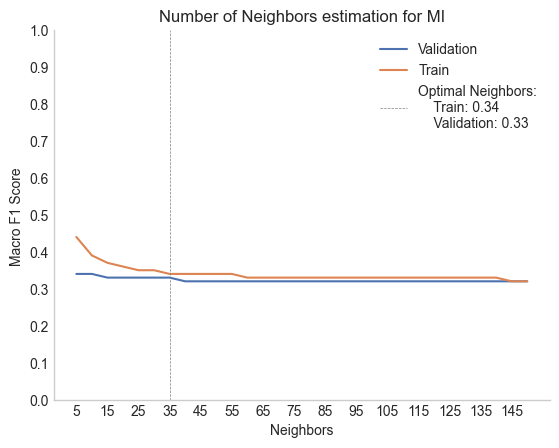

In [56]:
# Visualization for best K

estimate_knn = compare_models_df(estimate_knn_gs, {"model__n_neighbors": "neighbors"})


estimate_knn["F1 Train Score"] = (
    estimate_knn["F1 Train Score"].str.split("±").str[0].str.strip().astype(float)
)


estimate_knn["F1 Validation Score"] = (
    estimate_knn["F1 Validation Score"].str.split("±").str[0].str.strip().astype(float)
)


train_score_35 = estimate_knn.loc[
    estimate_knn["neighbors"] == 35, "F1 Train Score"
].values[0]


validation_score_35 = estimate_knn.loc[
    estimate_knn["neighbors"] == 35, "F1 Validation Score"
].values[0]


sns.lineplot(
    x="neighbors",
    y="F1 Validation Score",
    data=estimate_knn,
    label="Validation",
)


sns.lineplot(x="neighbors", y="F1 Train Score", data=estimate_knn, label="Train")


plt.axvline(
    x=35,
    color="gray",
    linestyle="--",
    label=f"Optimal Neighbors:\n    Train: {train_score_35:.2f}\n    Validation: {validation_score_35:.2f}",
    linewidth=0.5,
)


plt.xticks(np.arange(5, 155, 10))


plt.yticks(np.arange(0, 1.1, 0.1))


plt.ylabel("Macro F1 Score ")


plt.xlabel("Neighbors")
plt.legend()


# plt.savefig("./figures/fs_neighbors.png", dpi=300, bbox_inches="tight")


plt.title("Number of Neighbors estimation for MI")


plt.show()

## 1.4. <a id='toc1_4_'></a>[Model Development](#toc0_)

### 1.4.1. <a id='toc1_4_1_'></a>[Base Models](#toc0_)

In [57]:
run = False

if run:

    start_time = time.time()

    pipeline = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    param_grid = [
        # Logistic Regression
        {
            "model": [LogisticRegression(max_iter=1000, class_weight="balanced")],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # Decision Tree
        {
            "model": [DecisionTreeClassifier(max_depth=15, class_weight="balanced")],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # K-Nearest Neighbors
        {
            "model": [KNeighborsClassifier(n_neighbors=35, weights="distance", p=1)],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # Gaussian Naive Bayes
        {
            "model": [GaussianNB()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # MLP Classifier
        {
            "model": [MLPClassifier((20, 20), learning_rate_init=0.01, max_iter=1000)],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
    ]

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/base_models.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    base_models_gs = load("./runs/base_models.joblib")

In [58]:
base_models_df = compare_models_df(
    base_models_gs, {"feature_selection__percentile": "FS Percentile"}
)

# Beautify for table
base_models_df["model_parameters"] = (
    base_models_df["model_parameters"]
    .apply(lambda text: (re.search(r"\((.*)\)", str(text), re.DOTALL).group(1)))
    .replace("", "base model")
    .str.replace("\n", "", regex=False)
)
base_models_df = base_models_df.sort_values(
    by=["model", "F1 Validation Score"], ascending=[False, False]
)

base_models_df = base_models_df.drop("preprocessing", axis=1)
# base_models_df.to_latex(
#     "./figures/tables/src/base_models.tex",
#     float_format="%.2f",
#     index=False,
#     escape=True,
# )
base_models_df

,model,model_parameters,FS Percentile,F1 Train Score,F1 Validation Score
13,MLPClassifier,"hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000",90,0.39 ± 0.02,0.37 ± 0.01
14,MLPClassifier,"hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000",70,0.37 ± 0.02,0.36 ± 0.02
12,MLPClassifier,"hidden_layer_sizes=(20, 20), learning_rate_init=0.01, max_iter=1000",50,0.36 ± 0.02,0.34 ± 0.01
1,LogisticRegression,"class_weight='balanced', max_iter=1000",90,0.32 ± 0.0,0.3 ± 0.01
2,LogisticRegression,"class_weight='balanced', max_iter=1000",70,0.31 ± 0.01,0.3 ± 0.01
0,LogisticRegression,"class_weight='balanced', max_iter=1000",50,0.3 ± 0.01,0.29 ± 0.02
6,KNeighborsClassifier,"n_neighbors=35, p=1, weights='distance'",50,1.0 ± 0.0,0.34 ± 0.01
8,KNeighborsClassifier,"n_neighbors=35, p=1, weights='distance'",70,1.0 ± 0.0,0.34 ± 0.01
7,KNeighborsClassifier,"n_neighbors=35, p=1, weights='distance'",90,1.0 ± 0.0,0.34 ± 0.0
9,GaussianNB,base model,50,0.27 ± 0.01,0.27 ± 0.01


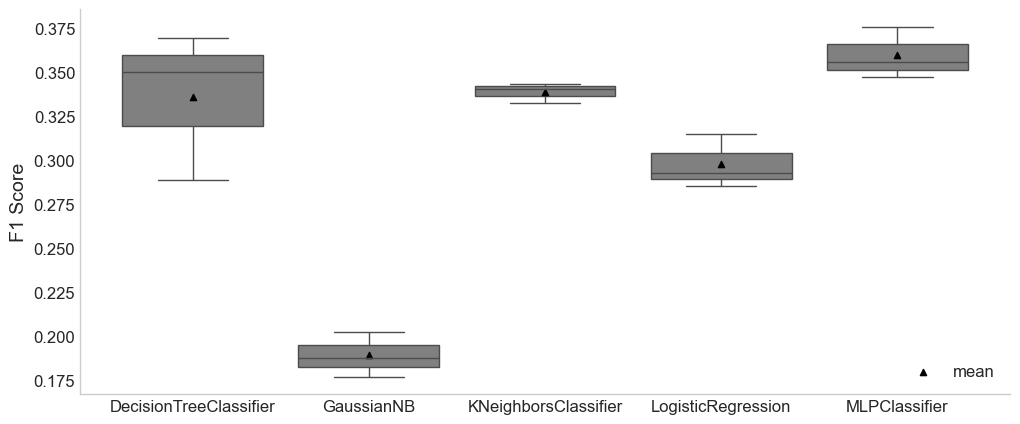

In [59]:
base_models_boxplot = compare_models_boxplots(base_models_gs)
# base_models_boxplot.savefig("./figures/base_models_comnparison.png", dpi=500, bbox_inches="tight")

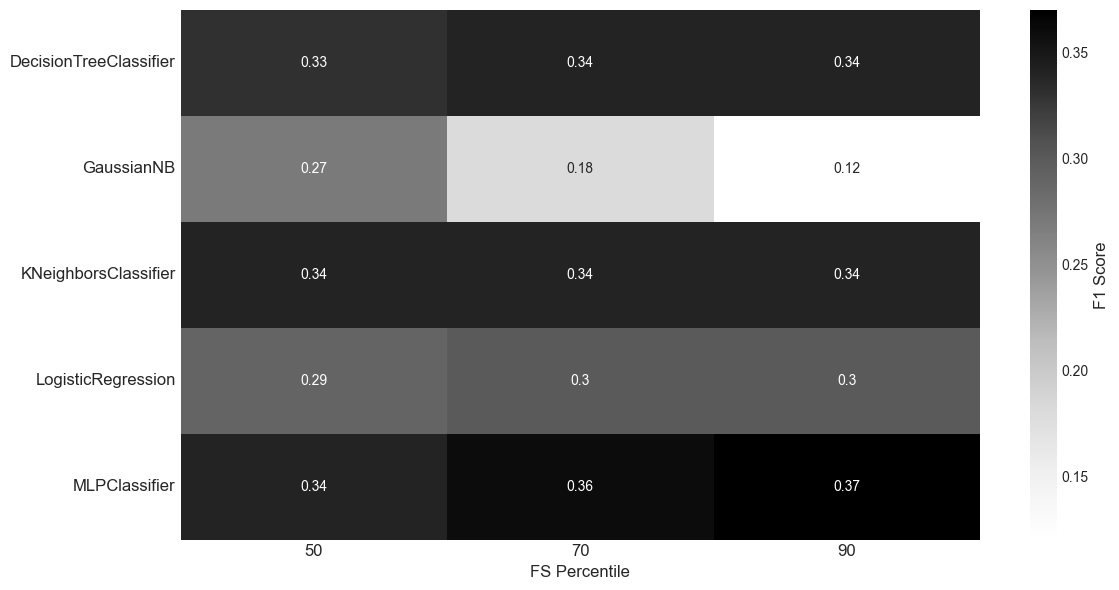

In [60]:
fs_differences = base_models_df[["FS Percentile", "F1 Validation Score", "model"]]

fs_differences["F1 Validation Score"] = (
    fs_differences["F1 Validation Score"]
    .str.split("±")
    .str[0]
    .str.strip()
    .astype(float)
)
pivot_data = fs_differences.pivot(
    index="model", columns="FS Percentile", values="F1 Validation Score"
)

plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(
    pivot_data, annot=True, cmap="Greys", cbar_kws={"label": "F1 Score"}
)
heatmap.figure.axes[-1].yaxis.label.set_size(12)

plt.xlabel("FS Percentile", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig(
#     "./figures/basemodel_FS_percentile_comparison.png.png", dpi=300, bbox_inches="tight"
# )

### 1.4.2. <a id='toc1_4_2_'></a>[Ensemble Models](#toc0_)

In [61]:
run = False

if run:

    start_time = time.time()

    pipeline = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    param_grid = [
        # Bagging with MLP
        {
            "model": [
                BaggingClassifier(
                    estimator=MLPClassifier(
                        (20, 20), learning_rate_init=0.01, max_iter=1000
                    ),
                    n_estimators=10,
                )
            ],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__max_samples": [0.8, 1.0],
            "model__max_features": [0.8, 1.0],
        },
        # Random Forest
        {
            "model": [RandomForestClassifier()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__n_estimators": [100, 200],
            "model__max_depth": [5, 10],
            "model__min_samples_split": [2, 5],
        },
        # AdaBoost
        {
            "model": [AdaBoostClassifier()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.05, 0.1],
        },
        # Gradient Boosting
        {
            "model": [GradientBoostingClassifier()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [5, 10],
        },
    ]

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/ensemble.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    ensemble_models_gs = load("./runs/ensemble.joblib")

In [62]:
ensemble_models_df = compare_models_df(ensemble_models_gs)


# Beautify for table


ensemble_models_df.loc[
    ensemble_models_df["model"] == "BaggingClassifier", "model_parameters"
] = (
    ensemble_models_df.loc[
        ensemble_models_df["model"] == "BaggingClassifier", "model_parameters"
    ]
    .apply(
        lambda text: (
            re.search(r"estimator=MLPClassifier\(.*?\)\)(.*)", str(text), re.DOTALL)
            .group(0)
            .rstrip("))}")
            if re.search(r"estimator=MLPClassifier\(.*?\)\)(.*)", str(text), re.DOTALL)
            else None
        )
    )
    .str.replace("\n", "", regex=False)
    .str.replace("))", " ")
    .str.replace("'", "")
    .str.replace("model__", "", regex=False)
)


ensemble_models_df.loc[
    ensemble_models_df["model"] == "BaggingClassifier", "model_parameters"
] = (
    ensemble_models_df.loc[
        ensemble_models_df["model"] == "BaggingClassifier", "model_parameters"
    ]
    + ", n_estimators=10"
)


ensemble_models_df.loc[
    ensemble_models_df["model"] != "BaggingClassifier", "model_parameters"
] = (
    ensemble_models_df.loc[
        ensemble_models_df["model"] != "BaggingClassifier", "model_parameters"
    ]
    .apply(
        lambda text: (
            re.search(r"\)(.*)", str(text), re.DOTALL)
            .group(1)
            .strip()
            .lstrip(",")
            .rstrip("}")
            if re.search(r"\)(.*)", str(text), re.DOTALL)
            else None
        )
    )
    .str.replace("'", "", regex=False)
    .str.replace("model__", "", regex=False)
)


ensemble_models_df = ensemble_models_df.sort_values(
    by=["model", "F1 Validation Score"], ascending=[False, False]
)

ensemble_models_df = ensemble_models_df.drop("preprocessing", axis=1)
# ensemble_models_df.to_latex(
#     "./figures/tables/src/ensembles.tex",
#     float_format="%.2f",
#     index=False,
#     escape=True,
# )


ensemble_models_df

,model,model_parameters,F1 Train Score,F1 Validation Score
8,RandomForestClassifier,"max_depth: 10, min_samples_split: 2, n_estimators: 100",0.36 ± 0.01,0.35 ± 0.0
9,RandomForestClassifier,"max_depth: 10, min_samples_split: 2, n_estimators: 200",0.36 ± 0.01,0.35 ± 0.0
10,RandomForestClassifier,"max_depth: 10, min_samples_split: 5, n_estimators: 100",0.36 ± 0.0,0.35 ± 0.0
11,RandomForestClassifier,"max_depth: 10, min_samples_split: 5, n_estimators: 200",0.36 ± 0.01,0.35 ± 0.0
5,RandomForestClassifier,"max_depth: 5, min_samples_split: 2, n_estimators: 200",0.25 ± 0.01,0.25 ± 0.01
6,RandomForestClassifier,"max_depth: 5, min_samples_split: 5, n_estimators: 100",0.25 ± 0.01,0.25 ± 0.01
7,RandomForestClassifier,"max_depth: 5, min_samples_split: 5, n_estimators: 200",0.25 ± 0.01,0.25 ± 0.01
4,RandomForestClassifier,"max_depth: 5, min_samples_split: 2, n_estimators: 100",0.25 ± 0.01,0.25 ± 0.0
17,GradientBoostingClassifier,"learning_rate: 0.05, max_depth: 5, n_estimators: 100",0.52 ± 0.03,0.4 ± 0.01
20,GradientBoostingClassifier,"learning_rate: 0.1, max_depth: 5, n_estimators: 50",0.46 ± 0.01,0.4 ± 0.01


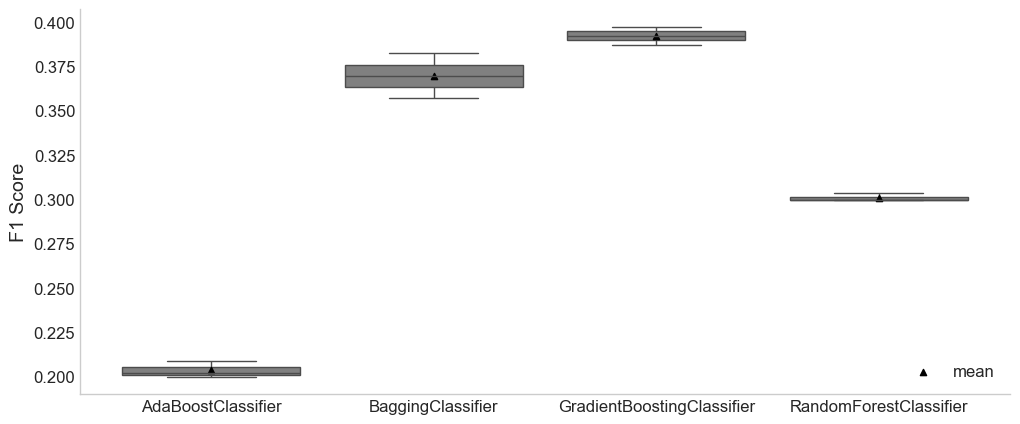

In [63]:
ensemble_base_boxplot = compare_models_boxplots(ensemble_models_gs)
# ensemble_base_boxplot.savefig(
#     "./figures/base_ensemble_comnparison.png", dpi=500, bbox_inches="tight"
# )

### 1.4.3. <a id='toc1_4_3_'></a>[Optimizing MLP hyperparameters](#toc0_)

In [64]:
run = False

if run:

    start_time = time.time()

    pipeline = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    param_grid = [
        {
            "model": [MLPClassifier()],
            "model__hidden_layer_sizes": [
                (20, 20, 20),
                (30, 30),
            ],
            "model__activation": ["relu", "tanh", "logistic"],
            "model__solver": ["adam", "sgd"],
            "model__learning_rate_init": [0.005, 0.01, 0.02],
            "model__learning_rate": ["constant", "adaptive", "invscaling"],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
        },
    ]
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/mlp_opt.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    mlp_opt_gs = load("./runs/mlp_opt.joblib")

In [65]:
results = mlp_opt_gs.cv_results_
keys_of_interest = [
    "param_model__activation",
    "param_model__hidden_layer_sizes",
    "param_model__learning_rate",
    "param_model__learning_rate_init",
    "param_model__solver",
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
]
results = {key: results[key] for key in keys_of_interest}

mlp_opt_df = pd.DataFrame(results)
mlp_opt_df = mlp_opt_df.round(2)
mlp_opt_df = mlp_opt_df.sort_values(by="mean_test_score", ascending=False)
mlp_opt_df["F1 Train Score"] = (
    mlp_opt_df["mean_train_score"].round(2).astype(str)
    + " ± "
    + mlp_opt_df["std_train_score"].round(2).astype(str)
)
mlp_opt_df["F1 Validation Score"] = (
    mlp_opt_df["mean_test_score"].round(2).astype(str)
    + " ± "
    + mlp_opt_df["std_test_score"].round(2).astype(str)
)

mlp_opt_df = mlp_opt_df.drop(
    [
        "mean_test_score",
        "std_test_score",
        "mean_train_score",
        "std_train_score",
    ],
    axis=1,
)
mlp_opt_df.columns = [
    "Activation Function",
    "Architecture",
    "Learning Rate",
    "Initial Learning Rate",
    "Solver",
    "F1 Train Score",
    "F1 Validation Score",
]

# mlp_opt_df.head(15).to_latex(
#     "./figures/tables/src/mlp_opt.tex",
#     float_format="%.2f",
#     index=False,
#     escape=True,
# )

mlp_opt_df

,Activation Function,Architecture,Learning Rate,Initial Learning Rate,Solver,F1 Train Score,F1 Validation Score
29,relu,"(30, 30)",adaptive,0.02,sgd,0.42 ± 0.01,0.4 ± 0.02
23,relu,"(30, 30)",constant,0.02,sgd,0.42 ± 0.01,0.4 ± 0.01
57,tanh,"(30, 30)",constant,0.01,sgd,0.41 ± 0.01,0.4 ± 0.01
11,relu,"(20, 20, 20)",adaptive,0.02,sgd,0.41 ± 0.01,0.39 ± 0.02
26,relu,"(30, 30)",adaptive,0.01,adam,0.41 ± 0.01,0.39 ± 0.01
...,...,...,...,...,...,...,...
89,logistic,"(20, 20, 20)",invscaling,0.02,sgd,0.21 ± 0.01,0.21 ± 0.0
105,logistic,"(30, 30)",invscaling,0.01,sgd,0.21 ± 0.0,0.21 ± 0.0
103,logistic,"(30, 30)",invscaling,0.00,sgd,0.2 ± 0.0,0.2 ± 0.0
87,logistic,"(20, 20, 20)",invscaling,0.01,sgd,0.19 ± 0.01,0.19 ± 0.01


### 1.4.4. <a id='toc1_4_4_'></a>[Bagging with MLP optimized & GBoost optimization](#toc0_)

In [66]:
run = False

if run:

    start_time = time.time()

    pipeline = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    best_mlp = MLPClassifier(
        (30, 30),
        activation="tanh",
        learning_rate="constant",
        learning_rate_init=0.01,
        max_iter=1000,
        solver="sgd",
    )

    param_grid = [
        # Bagging with MLP
        {
            "model": [
                BaggingClassifier(
                    estimator=best_mlp,
                )
            ],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__max_samples": [0.2, 0.4],
            "model__max_features": [0.8, 1.0],
            "model__n_estimators": [10, 30, 50],
        },
        # AdaBoost
        {
            "model": [AdaBoostClassifier(estimator=best_mlp)],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__n_estimators": [20, 50, 100],
            "model__learning_rate": [0.5, 0.1],
        },
        # Gradient Boosting
        {
            "model": [GradientBoostingClassifier()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.1, 0.5],
            "model__max_depth": [5, 10],
            "model__subsample": [0.5, 1],
            "model__max_features": [0.5, 1],
        },
    ]

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/ensemble_opt.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    ensemble_opt_models_gs = load("./runs/ensemble_opt.joblib")

In [67]:
ensemble_opt_models_df = compare_models_df(ensemble_opt_models_gs)
ensemble_opt_models_df = ensemble_opt_models_df[
    ensemble_opt_models_df["model"] != "AdaBoostClassifier"
]

# MLP Beautify
ensemble_opt_models_df.loc[
    ensemble_opt_models_df["model"] == "BaggingClassifier", "model_parameters"
] = (
    ensemble_opt_models_df.loc[
        ensemble_opt_models_df["model"] == "BaggingClassifier", "model_parameters"
    ]
    .apply(
        lambda text: (
            re.search(r"estimator=MLPClassifier\(.*?\)\)(.*)", str(text), re.DOTALL)
            .group(0)
            .rstrip("))}")
            if re.search(r"estimator=MLPClassifier\(.*?\)\)(.*)", str(text), re.DOTALL)
            else None
        )
    )
    .str.replace("\n", "", regex=False)
    .str.replace("))", " ")
    .str.replace("'", "")
    .str.replace("model__", "", regex=False)
)

ensemble_opt_models_df.loc[
    ensemble_opt_models_df["model"] == "BaggingClassifier", "model_parameters"
] = (
    ensemble_opt_models_df.loc[
        ensemble_opt_models_df["model"] == "BaggingClassifier", "model_parameters"
    ]
    + ", n_estimators=10"
)

# GBOOST Beautify

ensemble_opt_models_df.loc[
    ensemble_opt_models_df["model"] != "BaggingClassifier", "model_parameters"
] = (
    ensemble_opt_models_df.loc[
        ensemble_opt_models_df["model"] != "BaggingClassifier", "model_parameters"
    ]
    .apply(
        lambda text: (
            re.search(r"\)(.*)", str(text), re.DOTALL)
            .group(1)
            .strip()
            .lstrip(",")
            .rstrip("}")
            if re.search(r"\)(.*)", str(text), re.DOTALL)
            else None
        )
    )
    .str.replace("'", "", regex=False)
    .str.replace("model__", "", regex=False)
)


ensemble_opt_models_df = ensemble_opt_models_df.sort_values(
    by=["model", "F1 Validation Score"], ascending=[True, False]
)

ensemble_opt_models_df = ensemble_opt_models_df.drop("preprocessing", axis=1)
# ensemble_opt_models_df.to_latex(
#     "./figures/tables/src/ensemble_opt.tex",
#     float_format="%.2f",
#     index=False,
#     escape=True,
# )
ensemble_opt_models_df
# Best models - 6,18

,model,model_parameters,F1 Train Score,F1 Validation Score
6,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 1.0, max_samples: 0.2, n_estimators: 10, n_estimators=10",0.4 ± 0.01,0.38 ± 0.01
10,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 1.0, max_samples: 0.4, n_estimators: 30, n_estimators=10",0.4 ± 0.01,0.38 ± 0.01
11,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 1.0, max_samples: 0.4, n_estimators: 50, n_estimators=10",0.41 ± 0.01,0.38 ± 0.01
3,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 0.8, max_samples: 0.4, n_estimators: 10, n_estimators=10",0.39 ± 0.0,0.37 ± 0.01
4,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 0.8, max_samples: 0.4, n_estimators: 30, n_estimators=10",0.39 ± 0.01,0.37 ± 0.01
9,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 1.0, max_samples: 0.4, n_estimators: 10, n_estimators=10",0.4 ± 0.01,0.37 ± 0.01
5,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 0.8, max_samples: 0.4, n_estimators: 50, n_estimators=10",0.38 ± 0.02,0.37 ± 0.0
7,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 1.0, max_samples: 0.2, n_estimators: 30, n_estimators=10",0.39 ± 0.02,0.37 ± 0.0
8,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 1.0, max_samples: 0.2, n_estimators: 50, n_estimators=10",0.39 ± 0.01,0.37 ± 0.0
1,BaggingClassifier,"estimator=MLPClassifier(activation=tanh, hidden_layer_sizes=(30, 30), learning_rate_init=0.01, max_iter=1000, solver=sgd , max_features: 0.8, max_samples: 0.2, n_estimators: 30, n_estimators=10",0.37 ± 0.01,0.36 ± 0.0


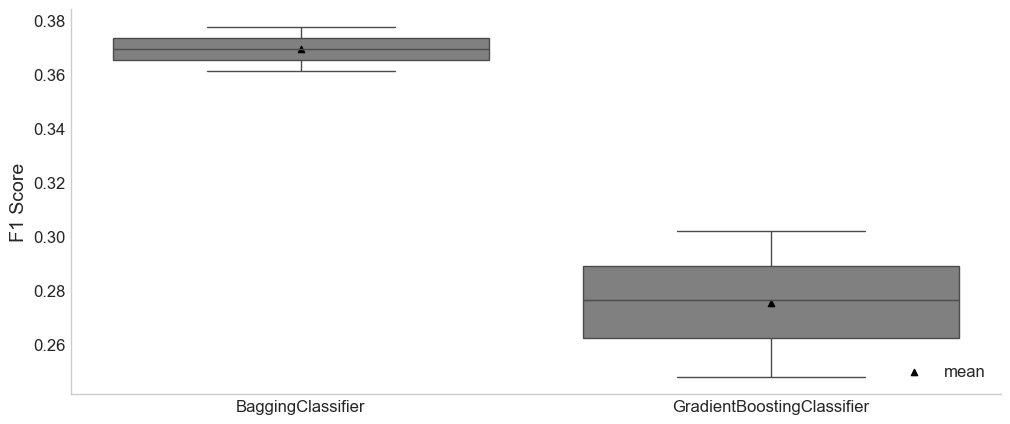

In [68]:
results = ensemble_opt_models_gs.cv_results_
results_no_folder = compare_models_df(ensemble_opt_models_gs)
validation_scores_folds = np.array(
    [results[f"split{fold}_test_score"] for fold in range(3)]
).T

validation_scores_folds = pd.DataFrame(
    validation_scores_folds,
    columns=[f"Validation F1_Fold_{fold}" for fold in range(3)],
    index=results_no_folder.index,
)

df_folds = pd.concat(
    (
        results_no_folder["model"],
        validation_scores_folds,
    ),
    axis=1,
)
df_folds = df_folds.dropna(axis=0)

df_folds = df_folds.groupby("model").mean().T
means = df_folds.mean(axis=0)

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df_folds, color="grey", ax=ax)
x_positions = range(len(means))
ax.scatter(x_positions, means, color="black", zorder=2, marker="^", s=20, label="mean")
ax.legend(loc="lower right", fontsize=12)
ax.set_xlabel("")
ax.set_xticks(range(len(df_folds.columns)))
ax.set_xticklabels(df_folds.columns, fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("F1 Score", fontsize=14)
plt.show()
# plt.savefig("./figures/4. ensemble_opt_comparison.png", dpi=500, bbox_inches="tight")

### 1.4.5. <a id='toc1_4_5_'></a>[Stacking](#toc0_)

In [69]:
run = False

if run:

    start_time = time.time()

    pipeline = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    mlp_model = MLPClassifier(
        (30, 30),
        activation="tanh",
        learning_rate="constant",
        learning_rate_init=0.01,
        max_iter=1000,
        solver="sgd",
    )
    dt_model = DecisionTreeClassifier(class_weight="balanced", max_depth=10)
    nb_model = GaussianNB()
    bagging_model = BaggingClassifier(
        estimator=mlp_model, max_samples=0.2, n_estimators=10
    )
    gradient_boosting_model = GradientBoostingClassifier(
        learning_rate=0.1, max_depth=5, max_features=0.5, n_estimators=50, subsample=0.5
    )
    logistic_model = LogisticRegression(class_weight="balanced", max_iter=1000)

    param_grid = [
        # Bagging + Gradient Boosting
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("bagging", bagging_model),
                        ("gradient_boosting", gradient_boosting_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # Bagging only
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("bagging", bagging_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # Gradient Boosting only
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("gradient_boosting", gradient_boosting_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # MLP only
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("MLP", mlp_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # MLP + Decision Tree
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("MLP", mlp_model),
                        ("DT", dt_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # MLP + Decision Tree + Naive Bayes
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("MLP", mlp_model),
                        ("DT", dt_model),
                        ("NB", nb_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # MLP + Naive Bayes
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("MLP", mlp_model),
                        ("NB", nb_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # Bagging + Naive Bayes
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("bagging", bagging_model),
                        ("NB", nb_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # Gradient Boosting + Naive Bayes
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("gradient_boosting", gradient_boosting_model),
                        ("NB", nb_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # MLP + Logistic Regression
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("MLP", mlp_model),
                        ("Logistic Regression", logistic_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
        # MLP + Naive Bayes + Decision Tree + Logistic Regression
        {
            "preprocessing": [baseline],
            "feature_selection__percentile": [90],
            "model": [
                StackingClassifier(
                    estimators=[
                        ("MLP", mlp_model),
                        ("NB", nb_model),
                        ("DT", dt_model),
                        ("Logistic Regression", logistic_model),
                    ],
                    final_estimator=logistic_model,
                )
            ],
            "model__final_estimator__C": [0.1, 1.0, 10.0],
            "model__final_estimator__solver": ["saga", "lbfgs"],
        },
    ]

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
        refit=False,
    )

    gs.fit(X, y)
    dump(gs, "./runs/stacking.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    stacking_gs = load("./runs/stacking.joblib")

In [70]:
# Full table
all_estimator_names = []
stacking_df = compare_models_df(stacking_gs)
for stacking_model in stacking_gs.cv_results_["param_model"]:
    estimator_names = [estimator[0] for estimator in stacking_model.estimators]
    all_estimator_names.append(estimator_names)


stacking_df["model"] = all_estimator_names
stacking_df["model"] = stacking_df["model"].apply(lambda x: ", ".join(x))
stacking_df = stacking_df[["model", "F1 Train Score", "F1 Validation Score"]]
stacking_df = stacking_df.sort_values(
    by=["model", "F1 Validation Score"], ascending=[False, False]
)

stacking_df

,model,F1 Train Score,F1 Validation Score
51,"gradient_boosting, NB",0.35 ± 0.01,0.34 ± 0.01
53,"gradient_boosting, NB",0.35 ± 0.01,0.34 ± 0.01
49,"gradient_boosting, NB",0.34 ± 0.0,0.33 ± 0.01
48,"gradient_boosting, NB",0.31 ± 0.03,0.29 ± 0.02
50,"gradient_boosting, NB",0.29 ± 0.08,0.26 ± 0.05
...,...,...,...
21,MLP,0.37 ± 0.06,0.35 ± 0.04
19,MLP,0.36 ± 0.06,0.34 ± 0.05
18,MLP,0.28 ± 0.06,0.26 ± 0.07
22,MLP,0.24 ± 0.03,0.22 ± 0.04


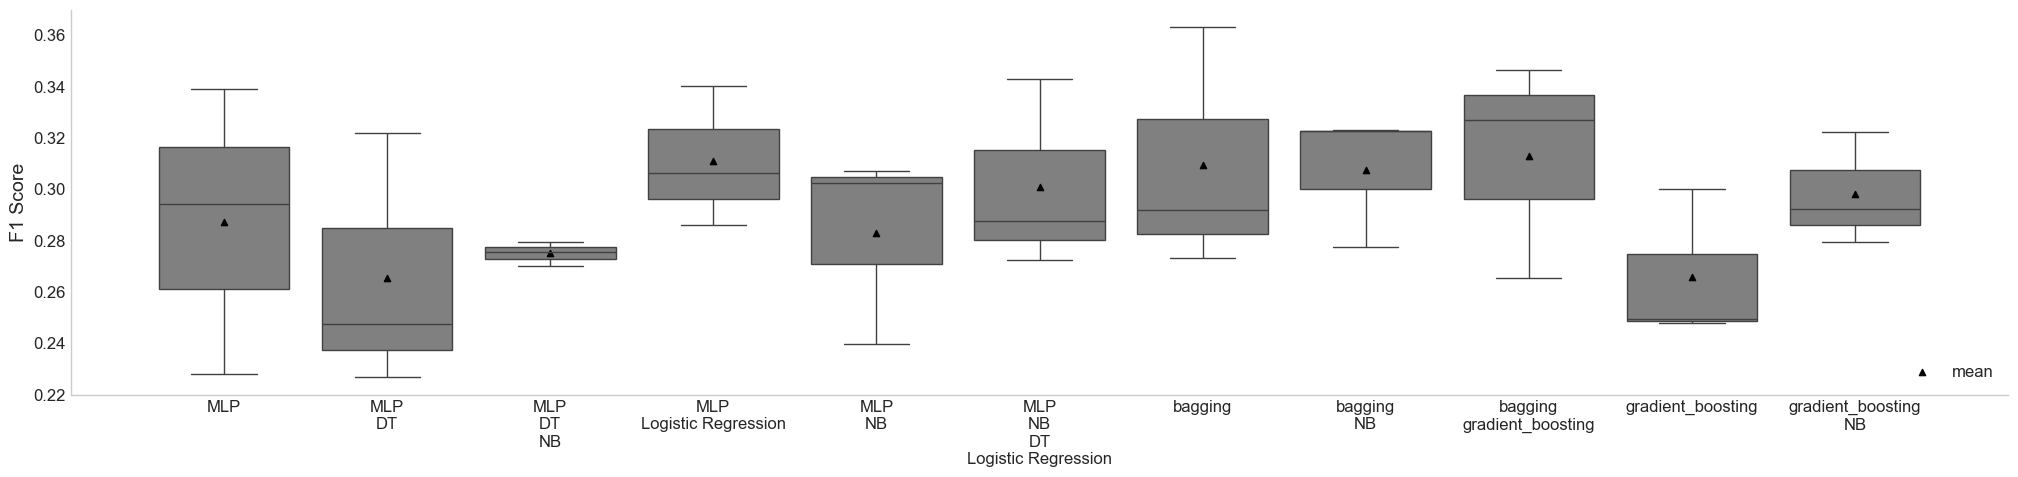

In [71]:
splits_scores = pd.DataFrame(
    {
        "Estimator": all_estimator_names,
        "Split0 Test Score": stacking_gs.cv_results_["split0_test_score"],
        "Split1 Test Score": stacking_gs.cv_results_["split1_test_score"],
        "Split2 Test Score": stacking_gs.cv_results_["split2_test_score"],
    }
)
splits_scores["Estimator"] = splits_scores["Estimator"].apply(lambda x: ", ".join(x))


splits_scores = splits_scores.groupby("Estimator").mean().T
means = splits_scores.mean(axis=0)
splits_scores
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(data=splits_scores, color="grey", ax=ax)
x_positions = range(len(means))
ax.scatter(x_positions, means, color="black", zorder=2, marker="^", s=20, label="mean")
ax.legend(loc="lower right", fontsize=12)
ax.set_xlabel("")
ax.set_xticklabels(
    [label.replace(", ", "\n") for label in splits_scores.columns], fontsize=12
)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("F1 Score", fontsize=14)
plt.show()

# plt.savefig("./figures/5. Stacking_comparison.png", dpi=500, bbox_inches="tight")

In [72]:
# Agg by estimators combinations Table
splits_scores = pd.DataFrame(
    {
        "Estimator": all_estimator_names,
        "Split0 Validation Score": stacking_gs.cv_results_["split0_test_score"],
        "Split1 Validation Score": stacking_gs.cv_results_["split1_test_score"],
        "Split2 Validation Score": stacking_gs.cv_results_["split2_test_score"],
        "Split0 Train Score": stacking_gs.cv_results_["split0_train_score"],
        "Split1 Train Score": stacking_gs.cv_results_["split1_train_score"],
        "Split2 Train Score": stacking_gs.cv_results_["split2_train_score"],
    }
)
splits_scores["Estimator"] = splits_scores["Estimator"].apply(lambda x: ", ".join(x))
splits_scores["F1 Validation Score"] = splits_scores[
    ["Split0 Validation Score", "Split1 Validation Score", "Split2 Validation Score"]
].mean(axis=1)
splits_scores["F1 Train Score"] = splits_scores[
    ["Split0 Train Score", "Split1 Train Score", "Split2 Train Score"]
].mean(axis=1)

splits_scores["F1 Validation Std"] = splits_scores[
    ["Split0 Validation Score", "Split1 Validation Score", "Split2 Validation Score"]
].std(axis=1)
splits_scores["F1 Train Std"] = splits_scores[
    ["Split0 Train Score", "Split1 Train Score", "Split2 Train Score"]
].std(axis=1)

splits_scores = splits_scores[
    [
        "Estimator",
        "F1 Validation Score",
        "F1 Train Score",
        "F1 Validation Std",
        "F1 Train Std",
    ]
]

splits_scores_grouped = (
    splits_scores.groupby("Estimator", as_index=False)
    .agg(
        {
            "F1 Validation Score": "mean",
            "F1 Train Score": "mean",
            "F1 Validation Std": "mean",
            "F1 Train Std": "mean",
        }
    )
    .round(2)
)
splits_scores_grouped["F1 Validation Score"] = splits_scores_grouped.apply(
    lambda row: f"{row['F1 Validation Score']:.2f} ± {row['F1 Validation Std']:.2f}",
    axis=1,
)
splits_scores_grouped["F1 Train Score"] = splits_scores_grouped.apply(
    lambda row: f"{row['F1 Train Score']:.2f} ± {row['F1 Train Std']:.2f}", axis=1
)
splits_scores_grouped = splits_scores_grouped[
    ["Estimator", "F1 Validation Score", "F1 Train Score"]
]
splits_scores_grouped["Estimator"] = splits_scores_grouped["Estimator"].apply(
    lambda x: x.replace("bagging", "Bagging(MLP)") if isinstance(x, str) else x
)
splits_scores_grouped["Estimator"] = splits_scores_grouped["Estimator"].apply(
    lambda x: (x.replace("gradient_boosting", "GBoost") if isinstance(x, str) else x)
)
splits_scores_grouped = splits_scores_grouped.sort_values(
    by="F1 Train Score", ascending=False
)
splits_scores_grouped = splits_scores_grouped.rename(
    columns={"Estimator": "Base Learners"}
)

# splits_scores_grouped.to_latex(
#     "./figures/tables/src/stacking.tex",
#     float_format="%.2f",
#     index=False,
#     escape=True,
# )
splits_scores_grouped

,Base Learners,F1 Validation Score,F1 Train Score
6,Bagging(MLP),0.31 ± 0.07,0.33 ± 0.08
8,"Bagging(MLP), GBoost",0.31 ± 0.06,0.33 ± 0.07
7,"Bagging(MLP), NB",0.31 ± 0.04,0.33 ± 0.04
5,"MLP, NB, DT, Logistic Regression",0.30 ± 0.04,0.33 ± 0.03
10,"GBoost, NB",0.30 ± 0.03,0.32 ± 0.04
3,"MLP, Logistic Regression",0.31 ± 0.03,0.32 ± 0.03
0,MLP,0.29 ± 0.07,0.30 ± 0.08
2,"MLP, DT, NB",0.27 ± 0.04,0.30 ± 0.05
1,"MLP, DT",0.27 ± 0.07,0.29 ± 0.08
9,GBoost,0.27 ± 0.06,0.29 ± 0.07


### 1.4.6. <a id='toc1_4_6_'></a>[Preprocessing Optimization](#toc0_)

In [73]:
cat_pipeline_v1 = Pipeline(
    steps=[
        (
            "feature_engineering",
            Categorical_Feature_Engineering(),
        ),
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encoder", CatEncoder(encoding_strategy="count")),
    ]
)


baseline_v1 = Pipeline(
    steps=[
        (
            "column_transformer",
            ColumnTransformer(
                transformers=[
                    ("num_pipeline", num_pipeline, num_cols),
                    ("cat_pipeline", cat_pipeline_v1, cat_cols),
                    ("bin_pipeline", bin_pipeline, bin_cols),
                ],
                remainder="drop",
                n_jobs=-1,
            ),
        ),
        (
            "union",
            FeatureUnion([("scaler", Pipeline(steps=[("scaler", None)]))]),
        ),
    ]
)

baseline_v1.name = "baseline_v1"

In [74]:
run = False

if run:

    start_time = time.time()

    pipeline_v1 = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    best_model_mlp = MLPClassifier(
        (30, 30),
        activation="tanh",
        learning_rate="constant",
        learning_rate_init=0.01,
        max_iter=1000,
        solver="sgd",
    )
    best_model_gboost = GradientBoostingClassifier(
        learning_rate=0.1, max_depth=5, max_features=0.5, n_estimators=50, subsample=0.5
    )

    param_grid = [
        {
            "model": [best_model_mlp, best_model_gboost],
            "preprocessing": [baseline_v1],
            "feature_selection__percentile": [90],
            # Scalers
            "preprocessing__union__scaler__scaler": [
                StandardScaler(),
                MinMaxScaler(),
                RobustScaler(),
            ],
            # Outlier capping method
            "preprocessing__column_transformer__num_pipeline__outlier_capping__method": [
                "iqr",
                "percentile",
            ],
            # Cat Encoding
            "preprocessing__column_transformer__cat_pipeline__encoder__encoding_strategy": [
                "count",
                "ordinal",
                "count_normalized",
            ],
        }
    ]

    gs = GridSearchCV(
        pipeline_v1,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
    )

    gs.fit(X, y)
    dump(gs, "./runs/pre_processing_opt.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    pre_processing_opt_gs = load("./runs/pre_processing_opt.joblib")

In [75]:
results = {
    key: pre_processing_opt_gs.cv_results_[key]
    for key in [
        "param_preprocessing__column_transformer__cat_pipeline__encoder__encoding_strategy",
        "param_preprocessing__column_transformer__num_pipeline__outlier_capping__method",
        "param_preprocessing__union__scaler__scaler",
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
        "split0_train_score",
        "split1_train_score",
        "split2_train_score",
    ]
}

model_name_list = []
for model in pre_processing_opt_gs.cv_results_["param_model"]:
    model_name_list.append(str(model).split("(")[0])

preprocessing_opt_df = pd.DataFrame(results)


preprocessing_opt_df["F1 Validation Score"] = preprocessing_opt_df[
    [
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
    ]
].mean(axis=1)


preprocessing_opt_df["F1 Train Score"] = preprocessing_opt_df[
    [
        "split0_train_score",
        "split1_train_score",
        "split2_train_score",
    ]
].mean(axis=1)


preprocessing_opt_df["F1 Validation Std"] = preprocessing_opt_df[
    [
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
    ]
].std(axis=1)


preprocessing_opt_df["F1 Train Std"] = preprocessing_opt_df[
    [
        "split0_train_score",
        "split1_train_score",
        "split2_train_score",
    ]
].std(axis=1)


preprocessing_opt_df["F1 Validation Score"] = preprocessing_opt_df.apply(
    lambda row: f"{row['F1 Validation Score']:.2f} ± {row['F1 Validation Std']:.2f}",
    axis=1,
)
preprocessing_opt_df["F1 Train Score"] = preprocessing_opt_df.apply(
    lambda row: f"{row['F1 Train Score']:.2f} ± {row['F1 Train Std']:.2f}", axis=1
)


preprocessing_opt_df.columns = [
    "Encoding Strategy",
    "Outlier Detection",
    "Scaler",
] + list(preprocessing_opt_df.columns[3:])

preprocessing_opt_df["Model"] = model_name_list


preprocessing_opt_df = preprocessing_opt_df[
    [
        "Model",
        "Encoding Strategy",
        "Outlier Detection",
        "Scaler",
        "F1 Train Score",
        "F1 Validation Score",
    ]
]


preprocessing_opt_df["Scaler"] = (
    preprocessing_opt_df["Scaler"].astype(str).str.replace("()", "")
)
preprocessing_opt_df["Outlier Detection"] = preprocessing_opt_df[
    "Outlier Detection"
].replace(
    {
        "iqr": "IQR",
        "percentile": "Percentile",
    }
)
preprocessing_opt_df["Encoding Strategy"] = preprocessing_opt_df[
    "Encoding Strategy"
].replace(
    {
        "count": "Frequency Encoder",
        "ordinal": "Ordinal Encoder",
        "count_normalized": "Frequency Encoder Normalized",
    }
)


preprocessing_opt_df = preprocessing_opt_df.sort_values(
    by=["Model", "Encoding Strategy", "Outlier Detection", "F1 Validation Score"],
    ascending=[False, True, False, False],
)


# preprocessing_opt_df.to_latex(
#     "./figures/tables/src/preprocessing_opt.tex",
#     float_format="%.2f",
#     index=False,
#     escape=True,
# )

preprocessing_opt_df

,Model,Encoding Strategy,Outlier Detection,Scaler,F1 Train Score,F1 Validation Score
4,MLPClassifier,Frequency Encoder,Percentile,MinMaxScaler,0.41 ± 0.00,0.40 ± 0.02
3,MLPClassifier,Frequency Encoder,Percentile,StandardScaler,0.42 ± 0.02,0.39 ± 0.01
5,MLPClassifier,Frequency Encoder,Percentile,RobustScaler,0.28 ± 0.00,0.28 ± 0.01
0,MLPClassifier,Frequency Encoder,IQR,StandardScaler,0.41 ± 0.01,0.39 ± 0.02
1,MLPClassifier,Frequency Encoder,IQR,MinMaxScaler,0.40 ± 0.02,0.39 ± 0.01
2,MLPClassifier,Frequency Encoder,IQR,RobustScaler,0.36 ± 0.01,0.35 ± 0.00
15,MLPClassifier,Frequency Encoder Normalized,Percentile,StandardScaler,0.42 ± 0.01,0.40 ± 0.01
16,MLPClassifier,Frequency Encoder Normalized,Percentile,MinMaxScaler,0.42 ± 0.01,0.40 ± 0.01
17,MLPClassifier,Frequency Encoder Normalized,Percentile,RobustScaler,0.32 ± 0.02,0.31 ± 0.02
12,MLPClassifier,Frequency Encoder Normalized,IQR,StandardScaler,0.41 ± 0.01,0.39 ± 0.02


,precision,recall,f1-score,support
1. CANCELLED,0.72,0.43,0.54,12477.00
2. NON-COMP,0.85,0.98,0.91,291078.00
3. MED ONLY,0.46,0.07,0.13,68906.00
4. TEMPORARY,0.73,0.86,0.79,148507.00
5. PPD SCH LOSS,0.67,0.60,0.63,48280.00
6. PPD NSL,1.00,0.00,0.00,4211.00
7. PTD,1.00,0.00,0.00,97.00
8. DEATH,0.60,0.31,0.41,470.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.75,0.41,0.43,574026.00


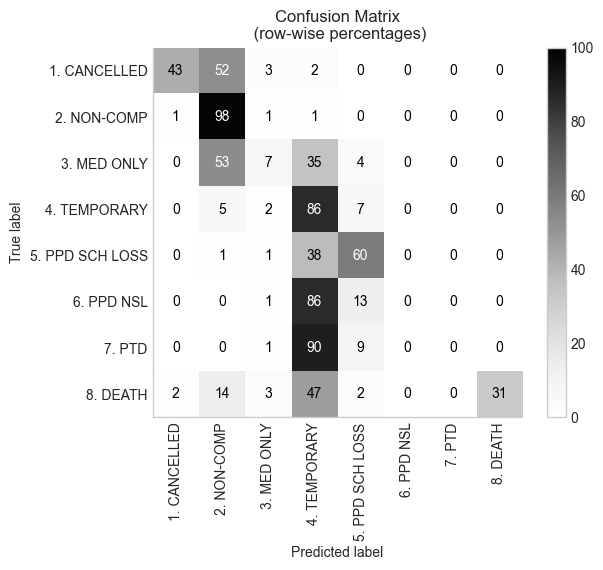

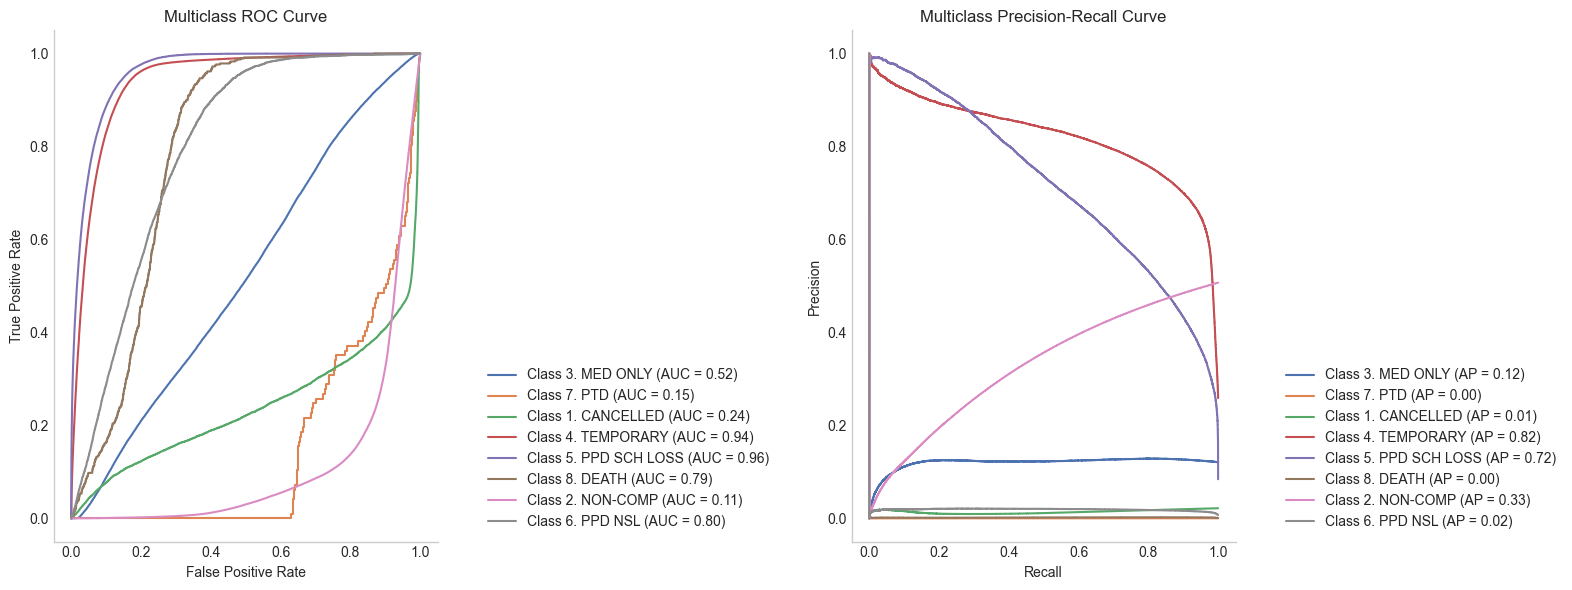

In [ ]:
report, cm, curves = analyse_best_model(pre_processing_opt_gs)

# report.to_latex(
#     "./figures/tables/src/final_model_cm.tex",
#     float_format="%.2f",
#     escape=True,
# )

# cm.savefig("./figures/8. final_model_CM.png", dpi=500, bbox_inches="tight")

# 2. <a id='toc2_'></a>[Open Ended Section - Oversampling & OVA](#toc0_)

In [77]:
best_num_pipeline = Pipeline(
    steps=[
        ("missing_values", MissingValueImputer_Numeric()),
        ("anomaly_fixer", AnomalyFixer_Numeric()),
        ("date_to_num", Num_Feature_Engineering()),
        ("imputation", SimpleImputer(strategy="median")),
        ("outlier_capping", OutlierCapper(method="percentile")),
    ]
)


best_cat_pipeline = Pipeline(
    steps=[
        (
            "feature_engineering",
            Categorical_Feature_Engineering(),
        ),
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encoder", CatEncoder(encoding_strategy="count")),
    ]
)

In [192]:
run = False

if run:

    start_time = time.time()

    smote_pipeline = ImbPipeline(
        steps=[
            (
                "preprocessing",
                ColumnTransformer(
                    transformers=[
                        ("num_pipeline", best_num_pipeline, num_cols),
                        ("cat_pipeline", best_cat_pipeline, cat_cols),
                        ("bin_pipeline", bin_pipeline, bin_cols),
                    ],
                    remainder="drop",
                    n_jobs=-1,
                ),
            ),
            (
                "feature_union",
                FeatureUnion(
                    [("scaler", Pipeline(steps=[("scaler", MinMaxScaler())]))]
                ),
            ),
            ("smote", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )

    best_model_mlp = MLPClassifier(
        (30, 30),
        activation="tanh",
        learning_rate="constant",
        learning_rate_init=0.01,
        max_iter=1000,
        solver="sgd",
    )

    param_grid = [
        # No resampling
        {
            "model": [
                OneVsRestClassifier(best_model_mlp, n_jobs=-1),
                best_model_mlp,
            ],
            "smote": [None],
            "feature_selection__percentile": [90],
        },
        # SMOTE
        {
            "model": [
                OneVsRestClassifier(best_model_mlp, n_jobs=-1),
                best_model_mlp,
            ],
            "smote": [SMOTE(sampling_strategy="auto", random_state=42)],
            "feature_selection__percentile": [90],
            "smote__k_neighbors": [5, 10],
        },
        # ADASYN
        {
            "model": [
                OneVsRestClassifier(best_model_mlp, n_jobs=-1),
                best_model_mlp,
            ],
            "smote": [ADASYN(sampling_strategy="auto", random_state=42)],
            "feature_selection__percentile": [90],
            "smote__n_neighbors": [5, 10],
        },
    ]

    gs = GridSearchCV(
        smote_pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
    )

    gs.fit(X, y)
    dump(gs, "./runs/smote_ova.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    smote_ova_gs = load("./runs/smote_ova.joblib")

In [125]:
smote_ova_df = compare_models_df(smote_ova_gs)

add_params = {
    key: smote_ova_gs.cv_results_[key]
    for key in ["param_smote", "param_smote__k_neighbors", "param_smote__n_neighbors"]
}

neighbors_smote = add_params["param_smote__k_neighbors"].data
neighbors_smote = [str(value) for value in neighbors_smote]
neighbors_adasyn = add_params["param_smote__n_neighbors"].data
neighbors_adasyn = np.where(neighbors_adasyn > 10, "-", neighbors_adasyn)
neighbors_adasyn = [str(value) for value in neighbors_adasyn]
print(neighbors_smote)
print(neighbors_adasyn)
print(add_params["param_smote"])

['0', '0', '5', '10', '5', '10', '0', '0', '0', '0']
['-', '-', '-', '-', '-', '-', '5', '10', '5', '10']
[None None SMOTE(random_state=42) SMOTE(random_state=42)
 SMOTE(random_state=42) SMOTE(random_state=42) ADASYN(random_state=42)
 ADASYN(random_state=42) ADASYN(random_state=42) ADASYN(random_state=42)]


In [145]:
smote_ova_df["Oversampling"] = add_params["param_smote"]
smote_ova_df["Neighbours"] = ["-", "-", "5", "10", "5", "10", "5", "10", "5", "10"]
smote_ova_df.rename(columns={"model": "Model"}, inplace=True)
smote_ova_df = smote_ova_df[
    ["Model", "Oversampling", "Neighbours", "F1 Train Score", "F1 Validation Score"]
]
smote_ova_df["Oversampling"] = smote_ova_df["Oversampling"].apply(
    lambda x: str(x).split("(")[0]
)

# smote_ova_df.to_latex(
#     "./figures/tables/src/ova_oversampling.tex",
#     float_format="%.2f",
#     index=False,
#     escape=True,
# )
smote_ova_df

,Model,Oversampling,Neighbours,F1 Train Score,F1 Validation Score
0,OneVsRestClassifier,None,-,0.39 ± 0.01,0.37 ± 0.0
1,MLPClassifier,None,-,0.42 ± 0.0,0.4 ± 0.01
2,OneVsRestClassifier,SMOTE,5,0.52 ± 0.01,0.37 ± 0.04
3,OneVsRestClassifier,SMOTE,10,0.52 ± 0.01,0.37 ± 0.03
4,MLPClassifier,SMOTE,5,0.46 ± 0.01,0.36 ± 0.02
5,MLPClassifier,SMOTE,10,0.44 ± 0.02,0.34 ± 0.05
6,OneVsRestClassifier,ADASYN,5,0.52 ± 0.02,0.35 ± 0.03
7,OneVsRestClassifier,ADASYN,10,0.52 ± 0.03,0.38 ± 0.02
8,MLPClassifier,ADASYN,5,0.44 ± 0.01,0.33 ± 0.03
9,MLPClassifier,ADASYN,10,0.43 ± 0.02,0.33 ± 0.06


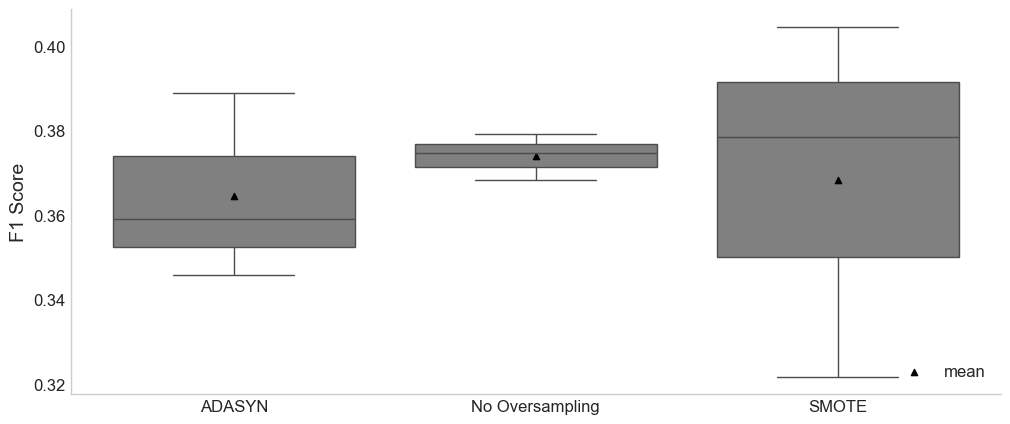

In [ ]:
validation_splits = {
    key: smote_ova_gs.cv_results_[key]
    for key in ["split0_test_score", "split1_test_score", "split2_test_score"]
}

viz_df = pd.concat((smote_ova_df, pd.DataFrame(validation_splits)), axis=1)
viz_df = viz_df.drop(["F1 Train Score", "F1 Validation Score"], axis=1)

OVR = viz_df[viz_df.Model == "OneVsRestClassifier"]
OVR["Oversampling"] = OVR["Oversampling"].astype(str)
OVR = OVR.groupby("Oversampling").mean(numeric_only=True).T
OVR.rename(columns={"None": "No Oversampling"}, inplace=True)

ovr_means = OVR.mean(axis=0)

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=OVR, color="grey", ax=ax)
x_positions = range(len(ovr_means))
ax.scatter(
    x_positions, ovr_means, color="black", zorder=2, marker="^", s=20, label="mean"
)
ax.legend(loc="lower right", fontsize=12)
ax.set_xlabel("")
ax.set_xticks(range(len(OVR.columns)))
ax.set_xticklabels(OVR.columns, fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("F1 Score", fontsize=14)
# plt.savefig(
#     "./figures/6. OVR_Oversampling_comparison.png", dpi=500, bbox_inches="tight"
# )
plt.show()

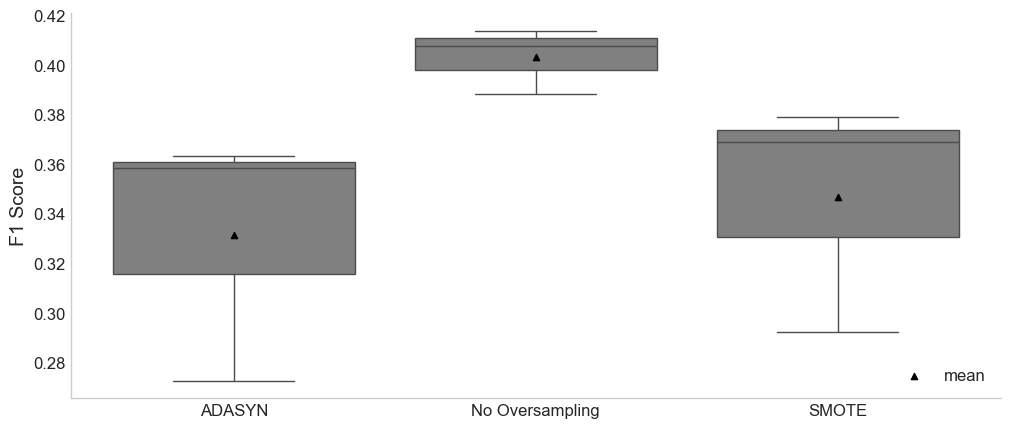

In [171]:
mlp = viz_df[viz_df.Model == "MLPClassifier"]
mlp["Oversampling"] = mlp["Oversampling"].astype(str)
mlp = mlp.groupby("Oversampling").mean(numeric_only=True).T
mlp.rename(columns={"None": "No Oversampling"}, inplace=True)

mlp_means = mlp.mean(axis=0)

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=mlp, color="grey", ax=ax)
x_positions = range(len(mlp_means))
ax.scatter(
    x_positions, mlp_means, color="black", zorder=2, marker="^", s=20, label="mean"
)
ax.legend(loc="lower right", fontsize=12)
ax.set_xlabel("")
ax.set_xticks(range(len(mlp.columns)))
ax.set_xticklabels(mlp.columns, fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("F1 Score", fontsize=14)

# plt.savefig(
#     "./figures/7. MLP_Oversampling_comparison.png", dpi=500, bbox_inches="tight"
# )
# plt.show()